# timm quickstart

https://github.com/huggingface/pytorch-image-models

In [ ]:
import timm

`timm` is a library containing SOTA computer vision models, layers, utilities, optimizers, schedulers, data-loaders, augmentations, and training/evaluation scripts.

## Load a Pretrained Model

Pretrained models can be loaded using `create_model()`.

Here, we load the pretrained `mobilenetv3_large_100` model.

Note: The returned PyTorch model is set to train mode by default, so you must call `.eval()` on it if you plan to use it for inference.

In [ ]:
m = timm.create_model('mobilenetv3_large_100', pretrained=True)
m.eval()

MobileNetV3(
  (conv_stem): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (bn1): BatchNormAct2d(
    16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
    (drop): Identity()
    (act): Hardswish()
  )
  (blocks): Sequential(
    (0): Sequential(
      (0): DepthwiseSeparableConv(
        (conv_dw): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
        (bn1): BatchNormAct2d(
          16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): ReLU(inplace=True)
        )
        (se): Identity()
        (conv_pw): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn2): BatchNormAct2d(
          16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): Identity()
        )
        (drop_path): Identity()
      )
    )
    (1): Sequential(
      (0): InvertedResidual(
 

## List Models with Pretrained Weights

To list models packaged with timm, you can use `list_models()`. If you specify `pretrained=True`, this function will only return model names that have associated pretrained weights available.

In [ ]:
from pprint import pprint

In [ ]:
model_names = timm.list_models(pretrained=True)
print(len(model_names))
pprint(model_names[:5])

1242
['bat_resnext26ts.ch_in1k',
 'beit_base_patch16_224.in22k_ft_in22k',
 'beit_base_patch16_224.in22k_ft_in22k_in1k',
 'beit_base_patch16_384.in22k_ft_in22k_in1k',
 'beit_large_patch16_224.in22k_ft_in22k']


You can also list models with a specific pattern in their name.

In [ ]:
model_names = timm.list_models('*resne*t*')
print(len(model_names))
pprint(model_names[:5])

156
['bat_resnext26ts',
 'cspresnet50',
 'cspresnet50d',
 'cspresnet50w',
 'cspresnext50']


## Fine-Tune a Pretrained Model

In [ ]:
model = timm.create_model('mobilenetv3_large_100', pretrained=True)
model.classifier

Linear(in_features=1280, out_features=1000, bias=True)

You can finetune any of the pre-trained models just by changing the classifier (the last layer).

In [ ]:
NUM_FINETUNE_CLASSES = 10
model = timm.create_model('mobilenetv3_large_100', pretrained=True, 
                          num_classes=NUM_FINETUNE_CLASSES)
model.classifier

Linear(in_features=1280, out_features=10, bias=True)

## Use a Pretrained Model for Feature Extraction

In [ ]:
import torch

In [ ]:
x = torch.randn(1, 3, 224, 224)
model = timm.create_model('mobilenetv3_large_100', pretrained=True)
output = model(x)
output.shape

torch.Size([1, 1000])

Without modifying the network, one can call `model.forward_features(input)` on any model instead of the usual `model(input)`. This will bypass the head classifier and global pooling for networks.

In [ ]:
features = model.forward_features(x)
features.shape

torch.Size([1, 960, 7, 7])

## Image Augmentation

To transform images into valid inputs for a model, you can use `timm.data.create_transform()`, providing the desired `input_size` that the model expects.

This will return a generic transform that uses reasonable defaults.

In [ ]:
timm.data.create_transform(input_size=(3, 224, 224))

Compose(
    Resize(size=256, interpolation=bilinear, max_size=None, antialias=True)
    CenterCrop(size=(224, 224))
    ToTensor()
    Normalize(mean=tensor([0.4850, 0.4560, 0.4060]), std=tensor([0.2290, 0.2240, 0.2250]))
)

Pretrained models have specific transforms that were applied to images fed into them while training. If you use the wrong transform on your image, the model won’t understand what it’s seeing!

To figure out which transformations were used for a given pretrained model, we can start by taking a look at its `pretrained_cfg`

In [ ]:
model.pretrained_cfg

{'url': 'https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/mobilenetv3_large_100_ra-f55367f5.pth',
 'hf_hub_id': 'timm/mobilenetv3_large_100.ra_in1k',
 'architecture': 'mobilenetv3_large_100',
 'tag': 'ra_in1k',
 'custom_load': False,
 'input_size': (3, 224, 224),
 'fixed_input_size': False,
 'interpolation': 'bicubic',
 'crop_pct': 0.875,
 'crop_mode': 'center',
 'mean': (0.485, 0.456, 0.406),
 'std': (0.229, 0.224, 0.225),
 'num_classes': 1000,
 'pool_size': (7, 7),
 'first_conv': 'conv_stem',
 'classifier': 'classifier'}

We can then resolve only the data related configuration by using `timm.data.resolve_data_config()`.

In [ ]:
timm.data.resolve_data_config(model.pretrained_cfg)

{'input_size': (3, 224, 224),
 'interpolation': 'bicubic',
 'mean': (0.485, 0.456, 0.406),
 'std': (0.229, 0.224, 0.225),
 'crop_pct': 0.875,
 'crop_mode': 'center'}

We can pass this data config to `timm.data.create_transform()` to initialize the model’s associated transform.

In [ ]:
data_cfg = timm.data.resolve_data_config(model.pretrained_cfg)
transform = timm.data.create_transform(**data_cfg)
transform

Compose(
    Resize(size=256, interpolation=bicubic, max_size=None, antialias=True)
    CenterCrop(size=(224, 224))
    ToTensor()
    Normalize(mean=tensor([0.4850, 0.4560, 0.4060]), std=tensor([0.2290, 0.2240, 0.2250]))
)

Note: Here, the pretrained model's config happens to be the same as the generic config we made earlier. This is not always the case. So, it's safer to use the data config to create the transform as we did here instead of using the generic transform.

## Using Pretrained Models for Inference

First we’ll need an image to do inference on. Here we load a picture of a leaf from the web:

https://github.com/EliSchwartz/imagenet-sample-images

Ground truth class: missile


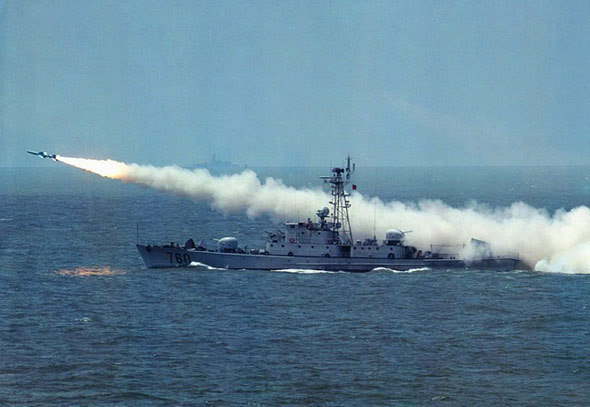

In [ ]:
import requests
from PIL import Image
from io import BytesIO

print("Ground truth class: missile")

url = 'https://github.com/EliSchwartz/imagenet-sample-images/blob/master/n03773504_missile.JPEG?raw=true'
image = Image.open(requests.get(url, stream=True).raw)
image

Now, we’ll create our model and transforms again. This time, we make sure to set our model in evaluation mode.

In [ ]:
model = timm.create_model('mobilenetv3_large_100', pretrained=True).eval()
transform = timm.data.create_transform(
    **timm.data.resolve_data_config(model.pretrained_cfg)
)

We can prepare this image for the model by passing it to the transform.

In [ ]:
image_tensor = transform(image)
image_tensor.shape

torch.Size([3, 224, 224])

Now we can pass that image to the model to get the predictions. We use `unsqueeze(0)` in this case, as the model is expecting a batch dimension.

In [ ]:
output = model(image_tensor.unsqueeze(0))
output.shape

torch.Size([1, 1000])

To get the predicted probabilities, we apply softmax to the output. This leaves us with a tensor of shape `(num_classes,)`.

In [ ]:
probabilities = torch.nn.functional.softmax(output[0], dim=0)
probabilities.shape

torch.Size([1000])

Now we’ll find the top 5 predicted class indexes and values using `torch.topk`.

In [ ]:
values, indices = torch.topk(probabilities, 5)
indices

tensor([657, 744, 403, 833, 554])

If we check the imagenet labels for the top index, we can see what the model predicted…

In [ ]:
IMAGENET_1k_URL = 'https://storage.googleapis.com/bit_models/ilsvrc2012_wordnet_lemmas.txt'
IMAGENET_1k_LABELS = requests.get(IMAGENET_1k_URL).text.strip().split('\n')

In [ ]:
[{'label': IMAGENET_1k_LABELS[idx], 'value': val.item()} for val, idx in zip(values, indices)]

[{'label': 'missile', 'value': 0.40311095118522644},
 {'label': 'projectile, missile', 'value': 0.1922902762889862},
 {'label': 'aircraft_carrier, carrier, flattop, attack_aircraft_carrier',
  'value': 0.136141836643219},
 {'label': 'submarine, pigboat, sub, U-boat', 'value': 0.021023472771048546},
 {'label': 'fireboat', 'value': 0.01885785162448883}]